<a href="https://colab.research.google.com/github/rb58853/images_RIS-ML-Conv-NLP/blob/main/end_model/caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.2 MB/s eta 0:00:00


### Importar bibliotecas


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

### Cargar Imagen
Cargar la imagen que se desea procesar. Para seleccionar una imagen distinta debe cambiar el valor de la variable `img_url`. Si desea cambiar el tamaño minimo que puede tener una segmentacion debe cambiar el valor de la variable `image_partition`.

In [ ]:
img_url = '/content/2.jpg'
raw_image = Image.open(img_url).convert("RGB")
image = cv2.imread(img_url)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_partition = 64 #tamaño mínimo(en píxeles) de un cuadro de segmentación = tamaño(imagen)/image_partition
weigth, heigth = raw_image.size
area = (weigth * heigth)/image_partition

Para visualizar la imagen cargada ejecutar celda:

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(image)
plt.axis('off')
plt.show()

# Cargar Modelos
Para cargar y ejecutar todos los modelos y funciones necesarias para procesar la imagen ejecutar las celdas que estan comprendidas en este encabezado.


## Segment Anything Model
Modelo de segmentación y funciones adicionales para procesar las salidas y entradas del mismo.


In [ ]:
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2ego1h08
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2ego1h08
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=4ae64796aed999d9b83474b87247facc352f8f340fddfcd93dad36292484f375
  Stored in directory: /tmp/pip-ephem-wheel-cache-7fbthhpo/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-10-29 15:48:32--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.106, 52.84.251.27, 5

#### Generar imágenes con las máscaras
Funciones para tratar con las máscaras de salida del modelo y generar imágenes usando esta.

In [ ]:
from PIL import Image

def mask_image(mask, raw_image, bbox):
    weigth, heigth = raw_image.size
    new_image = Image.new('RGBA', (weigth, heigth), (0, 0, 0, 0))

    original_pixles = raw_image.load()
    pixels = new_image.load()

    for i in range (heigth):
        for j in range (weigth):
            if mask[i,j]:
                pixels[j, i] = original_pixles[j,i]
            else:
                pass

    x,y,w,h =  bbox[0],bbox[1],bbox[2],bbox[3]
    return new_image.crop((x,y,x+w,y+h))

def bbox_image(bbox, image):
    x,y,w,h =  bbox[0],bbox[1],bbox[2],bbox[3]
    return image[y:y+h, x:x+w]

In [1]:
def all_areas_from_image(image, raw_image, min_area = 0, min_box_area = 0):
    """
    INPUTS:\n
    `image`: imagen cargada con cv2 \n
    `raw_image`: imagen cargada con PIL.Image \n
    `min_area`: area minima en pixeles de tamaño que puede puede tener las imagenes segmentadas \n
    `min_box_area`: area minima en pixeles de tamaño que puede puede tener un cuadro que contiene una imagen segmentada \n

    OUTPUTS: \n
    `dict` = \n
    `{` \n
      'box': imagenes(cuadro comprendido en segmentacion), \n
      'mask': imagenes(solo segmentacion fondo transparente) \n
    `}` \n
    """
    masks = mask_generator_2.generate(image)
    images_box= []
    images_mask= []
    for mask in masks:
        box_im = bbox_image(mask['bbox'],image)
        h, w, c = box_im.shape
        box_area = h * w
        if box_area >= min_box_area:
            images_box.append(box_im)
        if mask['area'] >= min_area:
            images_mask.append(mask_image(mask['segmentation'], raw_image, mask['bbox']))
    return {'box':images_box, 'mask':images_mask}

## BLIP

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

In [ ]:
def blip (_image):
    inputs = blip_processor(_image, return_tensors="pt").to("cuda")
    out = blip_model.generate(**inputs)
    result = blip_processor.decode(out[0], skip_special_tokens=True)

    if result[:9] == "there is ":
        result = result[9:]

    return result

def all_captions(image, raw_image, segmentation = 'box', min_area = 0, min_box_area = 0):
    """
    INPUTS:\n
    `image`: imagen cargada con cv2 \n
    `raw_image`: imagen cargada con PIL.Image\n
    `segmentation`: tipo de segmentacion que se va a utilizar para seleccionar imagenes ('box' o 'mask')\n
    `min_area`: area minima en pixeles de tamaño que puede puede tener las imagenes segmentadas \n
    `min_box_area`: area minima en pixeles de tamaño que puede puede tener un cuadro que contiene una imagen segmentada \n

    OUTPUTS: \n
    `list` = `[`lista con cada una de las descripciones de las imagenes segmentadas agregada al a descripcion principal`]`
    """
    areas = all_areas_from_image(image, raw_image, min_area,min_box_area)[segmentation]
    origin = str(blip(raw_image))
    captions = [origin]
    for im in areas:
        captions.append(origin +" "+ str(blip(im)))
    return captions

## CLIP

In [ ]:
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clip_model = clip_model.to(device)

In [ ]:
def select_caption(captions, image):
    """
    Usando el modelo CLIP selecciona la mejor descripcion de la lista de descripciones
    
    INPUTS:\n
    `captions`: lista de descripciones(texto) \n
    `image`: imagen a la cual hallar similitud con los textos\n

    OUTPUTS:\n
    `dict`:\n
    `{`\n
    'caption': texto con mayor similitud con la imagen (`str`)\n
    'probs': la lista de probabilidades que devuelve CLIP para esa imagen y textos(`list`) \n
    `}`
    """
    inputs = clip_processor(text=captions, images=image, return_tensors="pt", padding=True)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
    outputs = clip_model(**inputs)

    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)
    return {'caption':select_from_probs(probs, captions), 'probs': probs[0]}

def select_from_probs(probs, captions):
    max_prob = 0
    index = 0
    for i,prob in zip(range(len(probs[0])),probs[0]):
        if prob > max_prob:
            max_prob = prob
            index = i
    return captions[index]

def reduce_caption(caption, image):
    """
    Dada una descripcion se procesa la misma eliminando palabras innecesarias, se decide si la palabra es necesaria o no hallando similitud con CLIP\n

    INPUTS:\n
    `caption`: texto que se desea procesar\n
    `image`: imagen con la cual se desea hallar la similitud\n

    OUTPUTS:\n
    `str`: Nueva descripcion con palabras eliminadas
    """
    split = caption.split(' ')
    for word in split:
        temp = caption.split(' ')
        temp.remove(word)
        temp = ' '.join(temp)

        inputs = clip_processor(text=[temp, caption], images=image, return_tensors="pt", padding=True)
        inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

        if probs[0][0]> probs[0][1]:
            caption = temp


    return caption

In [ ]:
def short_captions(probs,captions):
    '''
    Ordena las descripciones usando como criterio de comparacion cual tiene mayor similitud con la imagen. Develve la lista de estos comop un diccionario `prob: caption` en orden de mejor similitud a peor similitud \n
    INPUTS:\n
    `probs`: lista de probabilidades en orden original \n
    `captions`: lista de descripciones en orden original\n
    OUTPUTS:\n
    `dict`= `{` porb(`float`): descripcion(`str`)`}`
    '''
    _probs = [prob.item() for prob in probs]
    for i in range(len(captions)):
        for j in range(i+1, len(captions)):
            if _probs[j]>_probs[i]:
                temp_p= _probs[i]
                temp_c = captions[i]
                _probs[i] = _probs[j]
                captions[i] = captions[j]
                _probs[j] = temp_p
                captions[j] = temp_c
    return {prob: caption for prob,caption in zip(_probs,captions) }

# Run Model
En estas celdas se ejecutan las funciones creadas y modelos cargados. Si las 3 celdas con un solo click, se mostrara el ranking de las 10 mejores descripciones encontradas y las descripciones de cada una de las imagenes segmentadas junto a su imagen correspondiente:

En esta celda usted puede cambiar los parametros que desee para variar los resultados


In [ ]:
# ['box' or 'mask'] DEFAULT: 'box'
_segmentation = 'box' 

# `int` DEFAULT: 64
image_partition = 64 
area = (weigth * heigth)/image_partition

# `int` cantidad de descripciones a mostrar DEFAULT: 10
count_rank = 10

# [`True` or `False`] Usar la descripcion reducida DEFAULT: True
use_reduc = True

In [ ]:
captions = all_captions(image, raw_image, min_box_area = area, segmentation = _segmentation)

In [ ]:
result = select_caption(captions, raw_image)
print("original_caption: "+str(result['caption']))
rduced_caption = reduce_caption(result['caption'], raw_image)
print("reduced_caption: "+str(rduced_caption), end= '\n\n')

if use_reduc and rduced_caption not in captions:
    captions.append(rduced_caption)

result = select_caption(captions, raw_image)
probs = result['probs']
end_captions = short_captions(probs, captions)

print("ranking: ")
end_key = None
last_print = False
for key,value,i in zip(end_captions.keys(),end_captions.values(),range(1000)):
    last_print = True
    if i < count_rank:
        print(str(i+1)+". {:.2f}".format(key * 100) + "%: "+ str(value))
        las_print = False
    end_key = key

if last_print:
    print(".\n.\n.\n"+str(len(end_captions.keys())) + ". {:.2f}".format(end_key * 100) + "%: "+ str(end_captions[end_key]))


original_caption: a cat and a dog laying on a bed together a very long knife with a long blade on it
reduced_caption: a cat and a dog laying a bed together a knife with a blade it

ranking: 
1. 66.61%: a cat and a dog laying a bed together a knife with a blade it
2. 14.68%: a cat and a dog laying on a bed together a very long knife with a long blade on it
3. 13.80%: a cat and a dog laying on a bed together a knife that is sitting on a table
4. 2.81%: a cat and a dog laying on a bed together there are two knives that are flying in the air
5. 1.68%: a cat and a dog laying on a bed together a close up of a person's hand with a toothbrush on it
6. 0.19%: a cat and a dog laying on a bed together a piece of cake on a plate with a fork
7. 0.07%: a cat and a dog laying on a bed together a slice of pizza on a plate with a fork
8. 0.04%: a cat and a dog laying on a bed together someone is holding a cell phone with a picture of a cat on it
9. 0.03%: a cat and a dog laying on a bed together a cat 

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


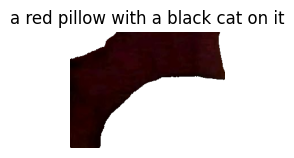

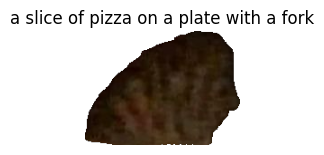

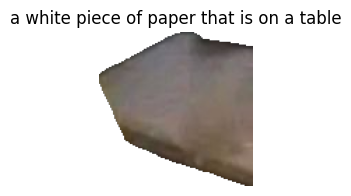

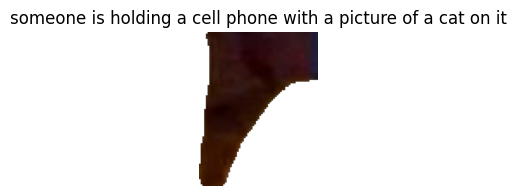

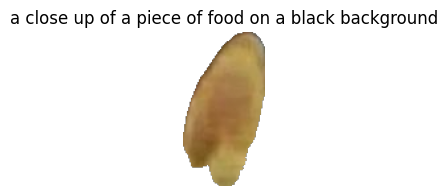

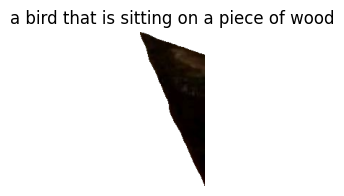

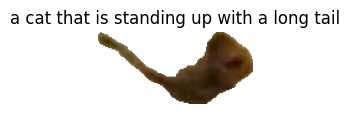

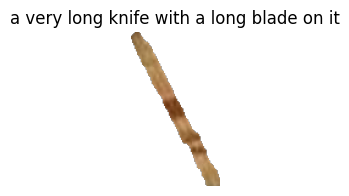

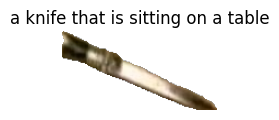

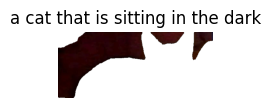

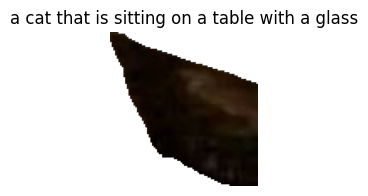

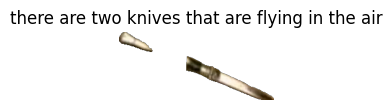

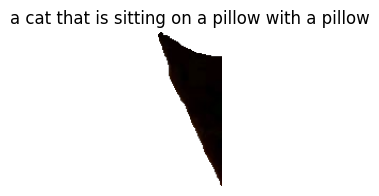

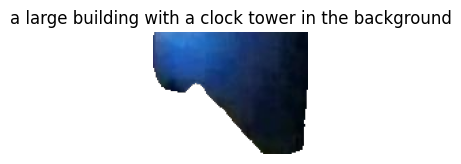

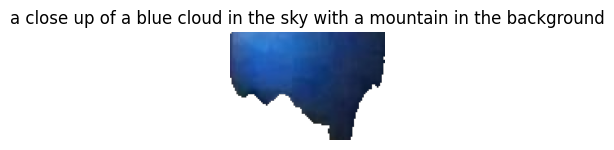

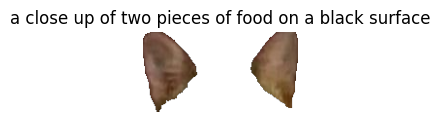

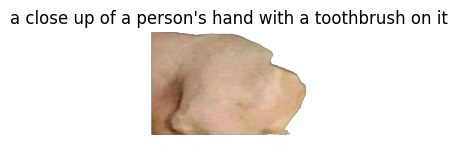

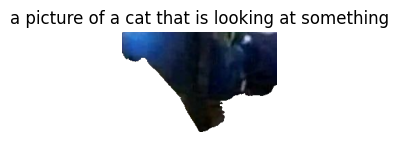

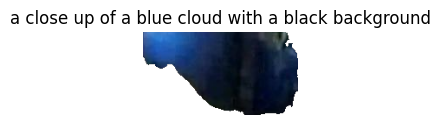

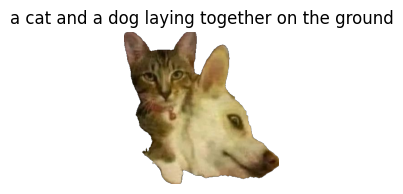

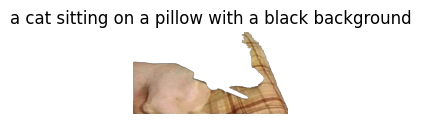

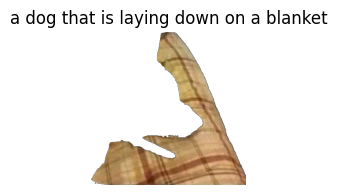

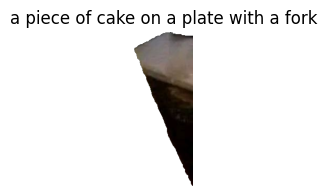

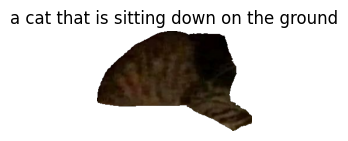

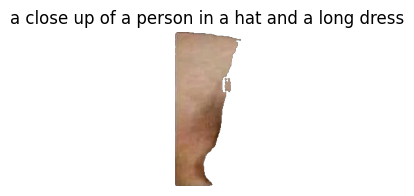

In [ ]:
# area = 0
images = all_areas_from_image(image, raw_image, min_box_area = area)['mask']
for im in images:
    plt.figure(figsize=(2,2))
    plt.title(blip(im))
    plt.imshow(im)
    plt.axis('off')
    plt.show()